<a href="https://colab.research.google.com/github/davidproton4u/AI-sampleassng/blob/main/Tensor_Flow_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem 1 - Looking Back at Scratch

Initialization of the weights and Bias

*   Epoch loop was needed
*   Number of nodes were determined and activation for each layer was performed
*   Training data was the mini-batch size
*   Assigned the linearly combined value to the activation function and passed the results to the next later (Forward Propagation)
*Computed the Loss Function
*Updated the weights and Biases (Error Back Propagation)
*Predicted with the validation data using the learned parameters











*Problem 2 - Consider the correspondence between scratch and TensorFlow

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.test.gpu_device_name() 

''

In [48]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [49]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [50]:
def example_net(x):
    """
    Simple 3-layer neural network
    """
    tf.random.set_random_seed(0)
    #Declaration of weights and biases
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    # tf.add and + are equivalent
    
    return layer_output

In [51]:
"""
Binar classification of Iris dataset using neural network implemented in TensorFlow
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#Load dataset
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)

#Condition extraction from data frame
df = df[(df["species"] == "Iris-versicolor") | (df["species"] == "Iris-virginica")]
y = df["species"]
X = df.loc[:, ["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = np.array(y)
X = np.array(X)

#Convert labels to numbers
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

#Further split into train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

#Read network structure                              
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

#Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimated result
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Estimated result
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#Initialize the variable
init = tf.global_variables_initializer()


#Run computational graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


<ipython-input-49-fd6094db6473>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


Epoch 0, loss : 37.4614, val_loss : 219.3430, acc : 0.625
Epoch 1, loss : 32.7593, val_loss : 190.8205, acc : 0.625
Epoch 2, loss : 28.1943, val_loss : 162.6565, acc : 0.625
Epoch 3, loss : 23.7451, val_loss : 135.2987, acc : 0.625
Epoch 4, loss : 19.4115, val_loss : 108.8010, acc : 0.625
Epoch 5, loss : 15.1615, val_loss : 82.7070, acc : 0.625
Epoch 6, loss : 10.9408, val_loss : 56.5563, acc : 0.625
Epoch 7, loss : 6.6616, val_loss : 29.8284, acc : 0.625
Epoch 8, loss : 2.2845, val_loss : 2.8463, acc : 0.500
Epoch 9, loss : 1.0791, val_loss : 19.3290, acc : 0.375
test_acc : 0.500


#Problem 3 - Create a model of Iris using all three types of objective variables

In [52]:
#Load dataset
dataset_path = "Iris.csv"
df_iris = pd.read_csv(dataset_path)

#Condition extraction from data frame
df_iris = df_iris[(df_iris["species"] == "Iris-setosa") 
                  |(df_iris["species"] == "Iris-versicolor")
                  |(df_iris["species"] == "Iris-virginica")
                  ]

y = df_iris["species"]
X = df_iris.loc[:, ["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = np.array(y)
X = np.array(X)

#Convert labels to numbers
y[y =='Iris-setosa'] = 0
y[y =='Iris-versicolor'] = 1
y[y =='Iris-virginica'] = 2

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:, np.newaxis])


#Split into train and test
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=0)

#Further split into train and Validation
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, test_size=0.2, random_state=0)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [53]:
print('y.shape:', y.shape)
print('X.shape:', X.shape)

y.shape: (150, 3)
X.shape: (150, 4)


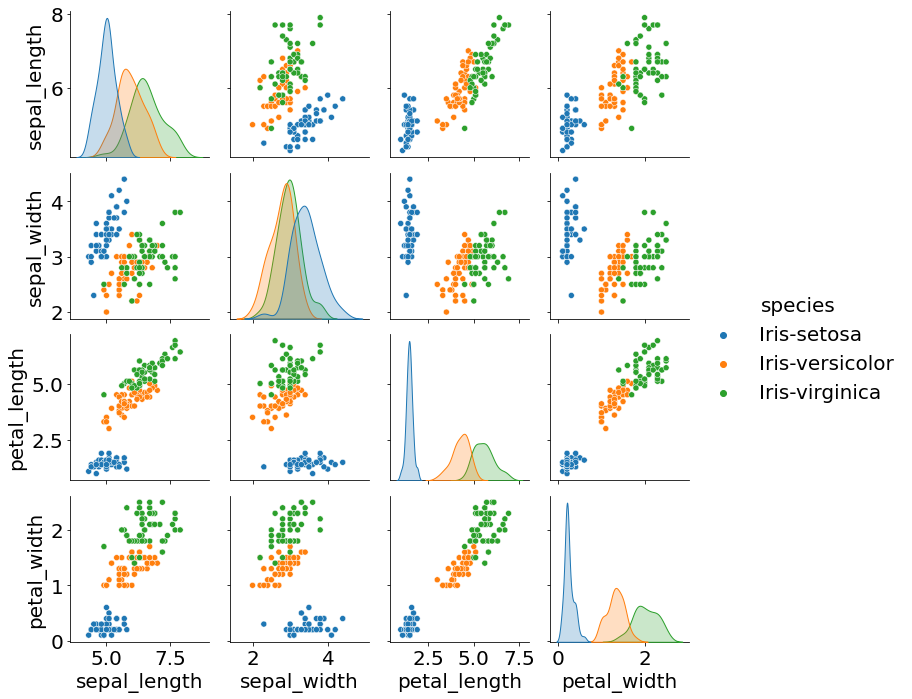

In [54]:
#Plot the Train Data
import seaborn as sns
sns.pairplot(df_iris,hue='species');

In [55]:
# Configure another set of Hyperparameter
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

#Read network structure                              
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=Y, logits=logits)
                        )

#Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimated result
correct_pred = tf.equal(tf.argmax(Y,1), tf.argmax(tf.nn.softmax(logits),1))

#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#Initialize the variable
init = tf.global_variables_initializer()


#Run computational graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run(
                [loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y}
            )
            total_loss += loss
            total_acc += acc

        total_loss /= n_samples
        total_acc /= n_samples

        val_loss, val_acc = sess.run(
            [loss_op, accuracy], feed_dict={X: X_val, Y: y_val}
        )
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}"
              .format(epoch, loss, val_loss, acc, val_acc))
    
    
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))



<ipython-input-49-fd6094db6473>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-55-27232016e660>:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


Epoch 0, loss : 70.0455, val_loss : 166.4679, acc : 0.667, val_acc : 0.292
Epoch 1, loss : 66.3092, val_loss : 134.5130, acc : 0.167, val_acc : 0.375
Epoch 2, loss : 41.7070, val_loss : 99.8014, acc : 0.667, val_acc : 0.375
Epoch 3, loss : 31.4888, val_loss : 66.1222, acc : 0.167, val_acc : 0.375
Epoch 4, loss : 17.1393, val_loss : 40.9955, acc : 0.667, val_acc : 0.333
Epoch 5, loss : 11.3286, val_loss : 21.9566, acc : 0.167, val_acc : 0.250
Epoch 6, loss : 3.5444, val_loss : 4.8538, acc : 0.667, val_acc : 0.500
Epoch 7, loss : 0.8128, val_loss : 0.4798, acc : 0.833, val_acc : 0.833
Epoch 8, loss : 0.2985, val_loss : 0.4104, acc : 0.833, val_acc : 0.875
Epoch 9, loss : 0.1261, val_loss : 0.3470, acc : 1.000, val_acc : 0.917
test_acc : 0.733


#Problem 4 - Create a model of House Prices
Create a model using House Prices, a data set for regression problems

In [56]:
#Loading the dataset
dataset_path = "train.csv"
df_house = pd.read_csv(dataset_path)

#Extracting Conditions from the data frame
y = df_house[['SalePrice']]
X = df_house[['GrLivArea', 'YearBuilt']]
y = np.array(np.log1p(y))
X = np.array(np.log1p(X))

#Split into train and test
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=0)

#Further split into train and Validation
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [57]:
print('y.shape:', y.shape)
print('X.shape:', X.shape)

y.shape: (1460, 1)
X.shape: (1460, 2)


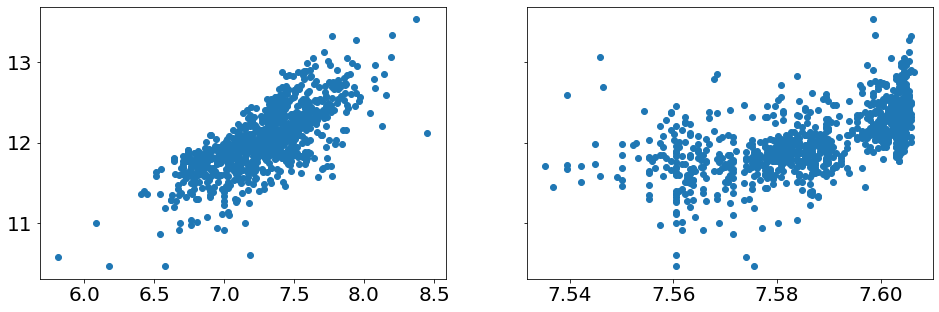

In [58]:
#Plotting the Train Data
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20
fig,ax = plt.subplots(1,2,sharey=True,figsize=(16, 5))

ax[0].scatter(X_train[:,0],y_train)
ax[1].scatter(X_train[:,1],y_train);

In [59]:
def regression_net(x):

    # Declaring the weights and biases
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }

    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    #tf.add and + are equivalent
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']

    return layer_output

In [60]:
# Configure another set of Hyperparameter
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_classes])

# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

#Read network structure                              
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.square(logits - Y))

#Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Index Value Calculation
mean_square_error = tf.reduce_mean(tf.square(logits - Y))

#Initialize the variable
init = tf.global_variables_initializer()


#Run computational graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_mse = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})

            loss, mse = sess.run([loss_op, mean_square_error], 
                                 feed_dict={X: mini_batch_x, Y: mini_batch_y}
            )
            total_loss += loss
            total_mse += mse

        total_loss /= n_samples
        total_mse /= n_samples

        val_loss, val_mse = sess.run([loss_op, mean_square_error], 
                                     feed_dict={X: X_val, Y: y_val}
        )
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, mse : {:.3f}, val_mse : {:.3f}"
              .format(epoch, loss, val_loss, mse, val_mse))
        
    test_mse = sess.run(mean_square_error, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_mse))


<ipython-input-49-fd6094db6473>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-60-a7275e5b36b3>:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


Epoch 0, loss : 0.7896, val_loss : 0.7433, mse : 0.790, val_mse : 0.743
Epoch 1, loss : 0.1968, val_loss : 0.3496, mse : 0.197, val_mse : 0.350
Epoch 2, loss : 0.0802, val_loss : 0.0962, mse : 0.080, val_mse : 0.096
Epoch 3, loss : 0.0829, val_loss : 0.0989, mse : 0.083, val_mse : 0.099
Epoch 4, loss : 0.0518, val_loss : 0.1685, mse : 0.052, val_mse : 0.169
Epoch 5, loss : 0.1435, val_loss : 0.3093, mse : 0.143, val_mse : 0.309
Epoch 6, loss : 0.2587, val_loss : 0.4612, mse : 0.259, val_mse : 0.461
Epoch 7, loss : 0.1749, val_loss : 0.3517, mse : 0.175, val_mse : 0.352
Epoch 8, loss : 0.4345, val_loss : 0.6772, mse : 0.435, val_mse : 0.677
Epoch 9, loss : 0.4597, val_loss : 0.7070, mse : 0.460, val_mse : 0.707
test_mse : 0.659


#Problem 5 - Create a model of MNIST
Create a model to classify the MNIST used in neural network scratches.

*It is similar to the previous Iris in that it is classified into 3 or more classes. The difference is that the input is an image.

*Aim to reproduce the model mounted by scratch.

In [61]:
# Download the MNIST Dataset
from keras.datasets import mnist
(X,y), (X_test, y_test) = mnist.load_data()


In [62]:
#Checking the Data imputed
print(X.shape)
print(X.shape)
print(X[0].dtype)

(60000, 28, 28)
(60000, 28, 28)
uint8


In [63]:
#Smooting
X = X.reshape(-1, 784)
X_test = X_test.reshape(-1,784)
print(X.shape) 
print(X_test.shape)

(60000, 784)
(10000, 784)


In [64]:
 #Type Conversion, Normalization
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255
print(x.max())
print(x.min())

<ipython-input-64-7b6c11acd852>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.float)
<ipython-input-64-7b6c11acd852>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = X_test.astype(np.float)


255
0


In [65]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])
print(y.shape)
print(y_one_hot.shape)
print(y_one_hot.dtype)

(60000,)
(60000, 10)
float64


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [66]:
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [71]:
def lenet(x):
    """
    CNN
    """
    #Declaration of weights and biases
    weights = {
        'w1': tf.Variable(tf.random_normal([5,5,1,6])),
        'w2': tf.Variable(tf.random_normal([5,5,6,16])),
        'w3': tf.Variable(tf.random_normal([7*7*16, 120])),
        'w4': tf.Variable(tf.random_normal([120,84])),
        'w5': tf.Variable(tf.random_normal([84, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([6])),
        'b2': tf.Variable(tf.random_normal([16])),
        'b3': tf.Variable(tf.random_normal([120])),
        'b4': tf.Variable(tf.random_normal([84])),
        'b5': tf.Variable(tf.random_normal([n_classes]))
    }

    x = tf.reshape(x, [-1, 28, 28, 1])
    conve_1 = tf.add(tf.nn.conv2d(x, weights['w1'],strides=[1,1,1,1],
                                 padding='SAME'),
                    biases['b1'])
    
    conve_1 = tf.nn.relu(conve_1)

    poolin_1 = tf.nn.pool(conve_1, window_shape=[2,2],strides=[2,2],
                          pooling_type='MAX', padding='VALID')
    
    conve_2 = tf.add(tf.nn.conv2d(poolin_1, weights['w2'],strides=[1,1,1,1],
                                  padding='SAME'),
                     biases['b2'])
    
    conve_2 = tf.nn.relu(conve_2)

    poolin_2 = tf.nn.pool(conve_2, window_shape=[2,2],strides=[2,2],
                          pooling_type='MAX', padding='VALID')
    
    X_reshape = tf.reshape(poolin_2, [-1,7*7*16])
    layer_1 = tf.add(tf.matmul(X_reshape, weights['w3']), biases['b3'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w4']), biases['b4'])
    layer_2 = tf.nn.relu(layer_2)
    # tf.add and + are equivalent
    layer_output = tf.matmul(layer_2, weights['w5']) + biases['b5']
    
    return layer_output

In [73]:
# Configure another set of Hyperparameter
learning_rate = 0.01
batch_size = 200
num_epochs = 30

n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

#Read network structure                              
logits = lenet(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                          labels=Y, logits=logits - Y)
                          )

#Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimated result
correct_pred = tf.equal(tf.argmax(Y,1), tf.argmax(tf.nn.softmax(logits),1))

#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#Initialize the variable
init = tf.global_variables_initializer()


#Run computational graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})

            loss, acc = sess.run(
                [loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc

        total_loss /= n_samples
        total_acc /= n_samples

        val_loss, val_acc = sess.run(
            [loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}"
              .format(epoch, loss, val_loss, acc, val_acc))
        
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


<ipython-input-49-fd6094db6473>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-73-c941be6f1b8e>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


Epoch 0, loss : 161.0783, val_loss : 166.9100, acc : 0.875, val_acc : 0.876
Epoch 1, loss : 70.7959, val_loss : 86.1193, acc : 0.925, val_acc : 0.911
Epoch 2, loss : 40.0525, val_loss : 60.0464, acc : 0.925, val_acc : 0.924
Epoch 3, loss : 21.8691, val_loss : 47.2030, acc : 0.935, val_acc : 0.930
Epoch 4, loss : 7.8988, val_loss : 36.5755, acc : 0.955, val_acc : 0.940
Epoch 5, loss : 6.5504, val_loss : 32.1519, acc : 0.955, val_acc : 0.943
Epoch 6, loss : 1.9095, val_loss : 29.4896, acc : 0.975, val_acc : 0.945
Epoch 7, loss : 2.6046, val_loss : 29.0290, acc : 0.985, val_acc : 0.945
Epoch 8, loss : 1.9287, val_loss : 27.8107, acc : 0.980, val_acc : 0.948
Epoch 9, loss : 0.8194, val_loss : 26.6035, acc : 0.985, val_acc : 0.948
Epoch 10, loss : 0.0000, val_loss : 24.5258, acc : 1.000, val_acc : 0.952
Epoch 11, loss : 0.0000, val_loss : 21.1344, acc : 1.000, val_acc : 0.955
Epoch 12, loss : 0.7150, val_loss : 24.4026, acc : 0.990, val_acc : 0.950
Epoch 13, loss : 0.2569, val_loss : 23.148